## Import

In [14]:
from IPython.display import display, Markdown
from collections import defaultdict
from functools import reduce
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Load Data

In [38]:
pd.set_option('display.max_rows', None)
df_codes = pd.read_csv('code.tsv', sep='\t', header=None, usecols=[0,1])
# load code mapping, e.g. "informed" to "I would like to stay informed"
codes = dict(zip(df_codes[0], df_codes[1]))
# includes incomplete results, only used for individual response stats
df0 = pd.read_csv('results.csv')
# clean results are used throughout this notebook
df = pd.read_csv('results_clean.csv')
df.head(5)

# can't make charts out of free text so remove it, custom LaTeX check mark macro shows present values
df_nocomments = df.fillna('').astype(str).replace("[A-Za-z].*","Y",regex=True).replace("Y","\\cmark")
# even rotated sideways and shrinked, the response table is hard to fit on a page so remove columns we don't need, such as the timestamp of an answer
latex_columns = ['id','consortium[berd]','consortium[daphne4nfdi]','consortium[dataplant]','consortium[fairagro]','consortium[fairmat]','consortium[ghga]','consortium[konsortswd]','consortium[mardi]','consortium[nfdi4biodiversity]','consortium[nfdi4bioimage]','consortium[nfdi4cat]','consortium[nfdi4chem]','consortium[nfdi4culture]','consortium[nfdi4datascience]','consortium[nfdi4earth]','consortium[nfdi4energy]','consortium[nfdi4health]','consortium[nfdi4immuno]','consortium[nfdi4ing]','consortium[nfdimatwerk]','consortium[nfdi4memory]','consortium[nfdi4microbiota]','consortium[nfdi4objects]','consortium[nfdixcs]','consortium[punch4nfdi]','consortium[text]','consortium[other]','role[developer]','role[researcher]','role[steward]','role[administrator]','role[manage]','role[unsure]','role[other]','solutions[build]','solutions[buildcomment]','solutions[link]','solutions[linkcomment]','solutions[structure]','solutions[structurecomment]','solutions[informed]','solutions[informedcomment]','solutions[uninterested]','solutions[uninterestedcomment]','solutions[other]','solutions[othercomment]','sustain[none]','sustain[hope]','sustain[community]','sustain[we]','sustain[other]','disseminate[socialmedia]','disseminate[webpage]','disseminate[publication]','disseminate[other]','metadata[codemeta]','metadata[citationcff]','metadata[zenodojson]','metadata[other]','ontologies','sourcecode[none]','sourcecode[private]','sourcecode[gitlab]','sourcecode[github]','sourcecode[unsure]','sourcecode[other]']
header=[r"\rotatebox{{90}}{{" + c + '}}' for c in latex_columns]
table_results = df_nocomments.to_latex(index=False,columns=latex_columns, header=header)
with open('table_results.tex', 'w') as f:
    f.write(table_results)

## Functions

In [35]:
# formats a set ("a","b","c") as a human readable list "(a, b, c)"
# will expand codes from the code list, for example ("nfdi4biodiversity","informed") is formated as "NFDI4Biodiversity, I would like to stay informed"
def format_set(s):
    if isinstance(s, set) or isinstance(s, frozenset):
        return ', '.join(sorted(map(lambda c: codes[c.lower()], s)))
    else:
        s = s.lower()
        if s in codes:
            return codes[s]
        return s

# 1. Add an aggregate column to the dataframe df.
# 2. Create and show a bar chart.
# 3. Return a dictionary with total count of each answer code where the count is > 0 sorted by answer key, for example ["berd": 5, "fairmat": 7]
# Parameters: prefix - the question code, title - the caption of the bar chart
# Background:
# There are different ways to represent multi-select questions that all have different tradeoffs.
# LimeSurvey chooses to give each answer code a_i to question code c it's own colum c[a_i] and represent chosen values with the "Y" character.
# We create a single aggregate column c with cell values being sets of answer codes a_i that are selected.
# For example, if a response for question code "consortium" has a "Y" character in columns "consortium[berd]" and "consortium[fairmat]" then the newly created aggregate column "consortium" for this column contains the set ("berd","fairmat").
def col_count(prefix,title):
    # prevent aggregate column from being aggregated with itself
    cols = {col for col in df.columns if isinstance(col, str) and col.startswith(prefix) and not "other" in col and not "comment" in col and col!=prefix}
    counts = {}
    df[prefix] = [set() for _ in range(len(df))]
    aggregate = df[prefix]
    for col in cols:
            # string type columns are mistakenly recognized as objects 
            df[col] = df[col].fillna('').astype(str)
            #display(df[col])
            new_col_name = re.sub(prefix+r"\[(.*)\]", lambda m: m.group(1), col)
            counts[new_col_name] = int((df[col] == 'Y').sum())
            named = df[col].replace('Y', new_col_name).astype(str)
            for index, _value in named.items():
                name = named.at[index]
                if name:
                     if not isinstance(name,str): 
                        display("Warning: name is not a string value : "+str(name))
         
            if new_col_name == 'OTHER':
                continue
            for index, _value in aggregate.items():
                cons = named.at[index]
                if cons:
                    if not isinstance(cons,str): 
                            display("Warning: consortium is not a string value : "+str(cons))
                            continue
                    if "{" in cons:
                        display("invalid character in consortium: '"+cons+"'")
                    #display("before",aggregate.at[index],"adding "+cons)
                    aggregate.at[index].add(cons)
                    #display("result:",aggregate.at[index])

    for index, value in aggregate.items():
        aggregate.at[index] = frozenset(aggregate.at[index]) # make it hashable
        
    df[prefix] = aggregate
 
    sorted_counts  = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    sorted_counts_series = pd.Series(sorted_counts)
    descriptive_counts_series = sorted_counts_series.rename(index=codes)
    descriptive_counts_series.plot(kind='bar', figsize=(10, 6), rot=90, title=title)
    yint = range(0, max(sorted_counts.values())+1) # automatic axis doesn't always show whole numbers
    plt.yticks(yint)
    plt.tight_layout()
    #plt.legend()
    plt.show()
    return sorted_counts


# if someone belongs to n consortia, count those only as 1/n for correct normalization of the other columns
# requires col_count("consortium","...") to be run first
def cons_count_normalize():
    counts = defaultdict(int)
    for consortia in df["consortium"]:
        for consortium in consortia:
            counts[consortium] += len(consortia)
    return counts


# normalization still in progress
def col_count_normalize(prefix,title):
    #cols = {col for col in df.columns if isinstance(col, str) and col.startswith(prefix)}
    counts = {}
    # aggregated consortium values created by calling col_count("consortium",...) first
    cons = df["consortium"]
    #display(cons)
    
    normalized_counts = defaultdict(int)
    aggregated = df[prefix]
    #for col in cols:
            #new_col_name = re.sub(prefix+r"\[(.*)\]", lambda m: m.group(1).upper(), col)
            #counts = int((df[col] == 'Y').sum())
    for index, values in aggregated.items():
            # using the aggregated column where the values are a set
            # alternatively we could also use the non-aggregated columns
            for value in values:
                consortia = cons.at[index]
            # ignore answers which did not specify a consortium, alternatively one could also assign a constant value to them
                if len(consortia)>0:
                    #display(consortia)
                    weights = list(map(lambda c: 1/max(1,cons_count_normalized[c]),consortia))
                    # the results get a bit wierd if people are part of multiple consortia
                    # feel free to propose a better way, or is there even a standard? We can't be the first ones with this problem.
                    weight = sum(weights)
                    normalized_counts[value] += weight
    sorted_counts  = dict(sorted(normalized_counts.items(), key=lambda item: item[1], reverse=True))
    sorted_counts_series = pd.Series(sorted_counts)
    descriptive_counts_series = sorted_counts_series.rename(index=codes)
    descriptive_counts_series.plot(kind='bar', figsize=(10, 6), rot=90, title=title+" (normalized)")
    plt.tight_layout()    
    plt.show()
    return normalized_counts

## Individual Responses

In [17]:
df0["startdate"] = pd.to_datetime(df0["startdate"]).dt.date
date_series = df0["startdate"].dropna()
mindate = date_series.min()
maxdate = date_series.max()
display("The "+str(len(df0))+" survey responses were submitted between "+mindate.strftime('%d %B %Y')+" and "+maxdate.strftime('%d %B %Y')+".")
df["startdate"] = pd.to_datetime(df["startdate"]).dt.date
date_series = df["startdate"].dropna()
mindate = date_series.min()
maxdate = date_series.max()
display("As most questions were optional to increase participations, incomplete, empty and test entries had to be removed afterwards, leaving "+str(len(df))+" survey responses submitted between "+mindate.strftime('%d %B %Y')+" and the extended end date of "+maxdate.strftime('%d %B %Y')+".")

'The 140 survey responses were submitted between 03 March 2025 and 14 April 2025.'

'As most questions were optional to increase participations, incomplete, empty and test entries had to be removed afterwards, leaving 51 survey responses submitted between 03 March 2025 and the extended end date of 14 April 2025.'

## Responses by Consortium

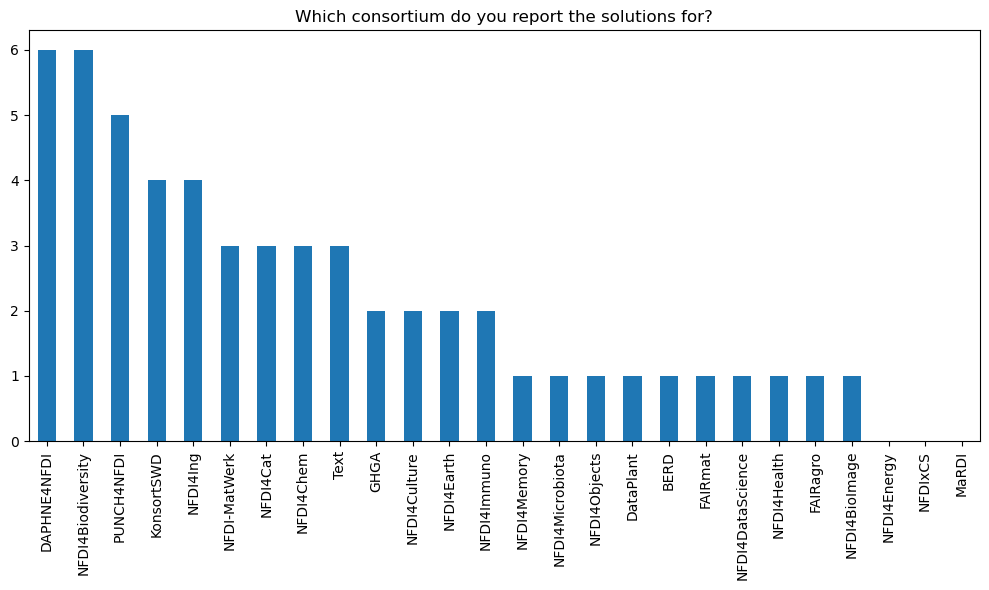

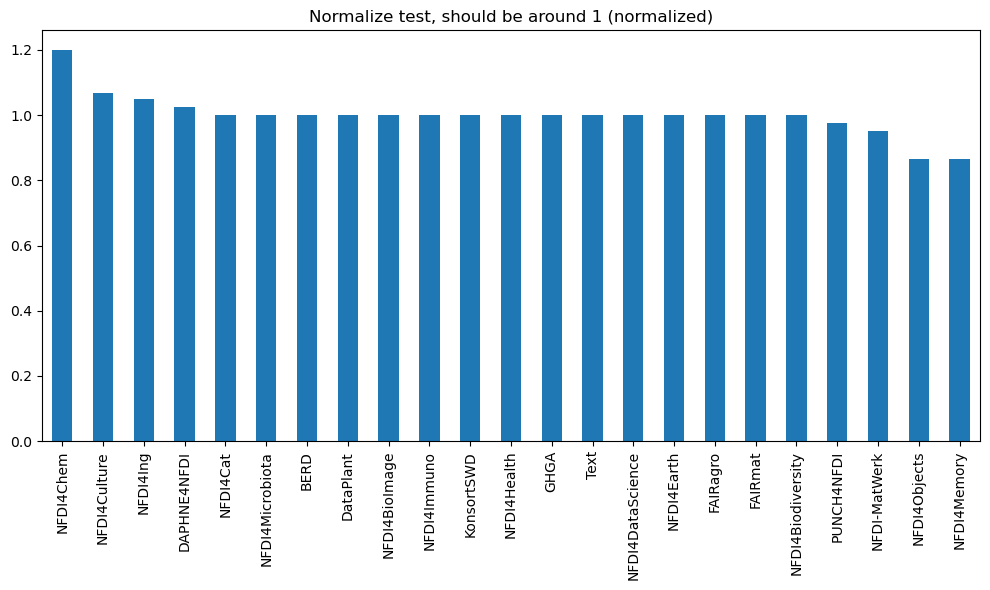

'Of the 26 consortia, 23 had at least one representative answer the survey, with no answer from MaRDI, NFDI4Energy, NFDIxCS'

In [18]:
cons_count = col_count("consortium","Which consortium do you report the solutions for?")
consortia_all = frozenset(cons_count.keys())

cons_count_normalized = cons_count_normalize()

# normalizing consoritium on itself does not produce helpful insights but we can verify that normalization works because the scores should all be 1 or close to it depending on how we treat special cases
# Python or Math experts, feel free to point out if I made errors somewhere or if you know a better formula for normalizations, but in the end I think it is not that cricial because we want to get a rough overview
cons_count_normalized = col_count_normalize("consortium","Normalize test, should be around 1")
consortia_answered = frozenset(cons_count_normalized.keys())
display(f"Of the {len(consortia_all)} consortia, {len(consortia_answered)} had at least one representative answer the survey, with no answer from {format_set(consortia_all.difference(consortia_answered))}")
#display(df["consortium"])


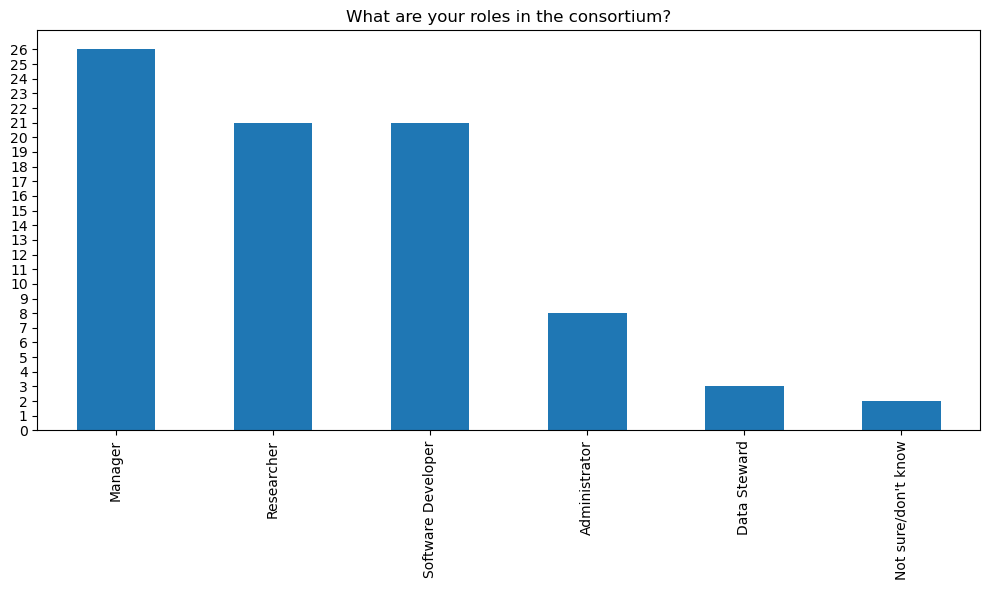

'Of the 51 participants, 26 identified themselves with the role of manager, 21 as researcher and 21 as developer.'

'Administrators (8) and stewards (3) were represented less and 2 were unsure.'

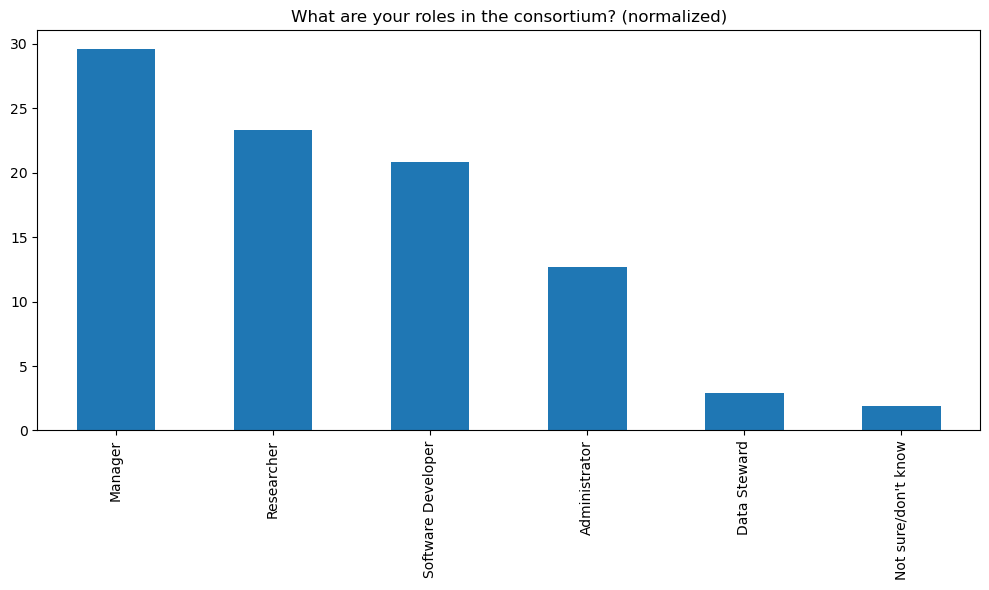

'The ranking of roles does not change between unnormalized and normalized values though the lead of managers over researchers is much larger in the normalized values.'

In [19]:
roles = col_count("role","What are your roles in the consortium?")
display(f"Of the {len(df)} participants, {roles["manage"]} identified themselves with the role of manager, {roles["researcher"]} as researcher and {roles["developer"]} as developer.")
display(f"Administrators ({roles["administrator"]}) and stewards ({roles["steward"]}) were represented less and {roles["unsure"]} were unsure.")
col_count_normalize("role","What are your roles in the consortium?")
display("The ranking of roles does not change between unnormalized and normalized values though the lead of managers over researchers is much larger in the normalized values.")


## Roles

In [20]:
roles_count = defaultdict(int)

for roles in df["role"]:
    roles_count[roles]+=1

roles_count = dict(sorted(roles_count.items(), key=lambda item: item[1], reverse = True) )
rcdf = pd.DataFrame(list(roles_count.items()), columns=['Role Combination', 'Count'])
table_role_combinations = rcdf.to_latex(index=False, formatters={"Role Combination": format_set})
print(table_role_combinations)
with open('table_role_combinations.tex', 'w') as f:
    f.write(table_role_combinations)

role_pairs = defaultdict(int)
roles = set(reduce(lambda a,b: a.union(b), roles_count.keys()))
roles.remove("unsure")
role_list = list(roles)

for i in range(0,len(roles)):
    a = role_list[i]
    for j in range(i+1,len(roles)):
        b = role_list[j]
        for row_roles in df["role"]:
            if a in row_roles and b in row_roles:    
                role_pairs[frozenset([a,b])]+=1

role_pairs = dict(sorted(role_pairs.items(), key=lambda item: item[1], reverse = True) )
rpdf = pd.DataFrame(list(role_pairs.items()), columns=['Role Pair', 'Count'])
table_role_pairs = rpdf.to_latex(index=False, formatters={"Role Pair": format_set})
print(table_role_pairs)
with open('table_role_pairs.tex', 'w') as f:
    f.write(table_role_pairs)

display("Some role pairs such as researcher and software developer occur more often than others but we do not categorize this as a problem with the role separation but instead a real phenomenon as for example software developers in research projects are often researchers.")


\begin{tabular}{lr}
\toprule
Role Combination & Count \\
\midrule
Manager & 16 \\
Researcher & 7 \\
Software Developer & 6 \\
Researcher, Software Developer & 4 \\
Administrator, Researcher, Software Developer & 3 \\
Manager, Researcher, Software Developer & 3 \\
Administrator, Manager, Software Developer & 2 \\
Manager, Researcher & 2 \\
Data Steward & 1 \\
Not sure/don't know & 1 \\
Administrator, Manager, Researcher & 1 \\
Administrator, Manager & 1 \\
Administrator, Manager, Researcher, Software Developer & 1 \\
Data Steward, Not sure/don't know, Software Developer & 1 \\
 & 1 \\
Data Steward, Software Developer & 1 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
Role Pair & Count \\
\midrule
Researcher, Software Developer & 11 \\
Manager, Researcher & 7 \\
Administrator, Software Developer & 6 \\
Manager, Software Developer & 6 \\
Administrator, Researcher & 5 \\
Administrator, Manager & 5 \\
Data Steward, Software Developer & 2 \\
\bottomrule
\end{tabular}



'Some role pairs such as researcher and software developer occur more often than others but we do not categorize this as a problem with the role separation but instead a real phenomenon as for example software developers in research projects are often researchers.'

## Participants

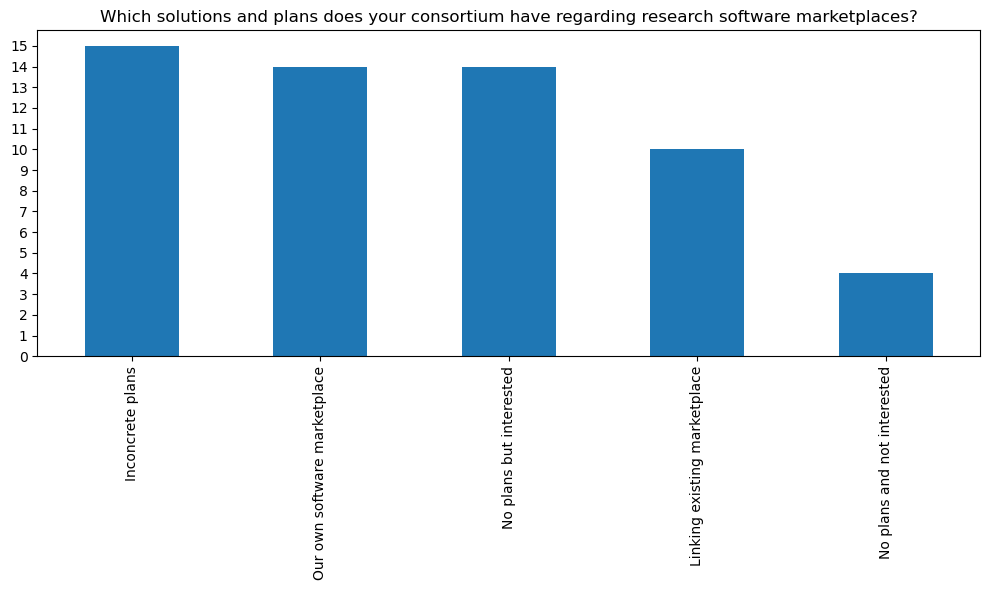

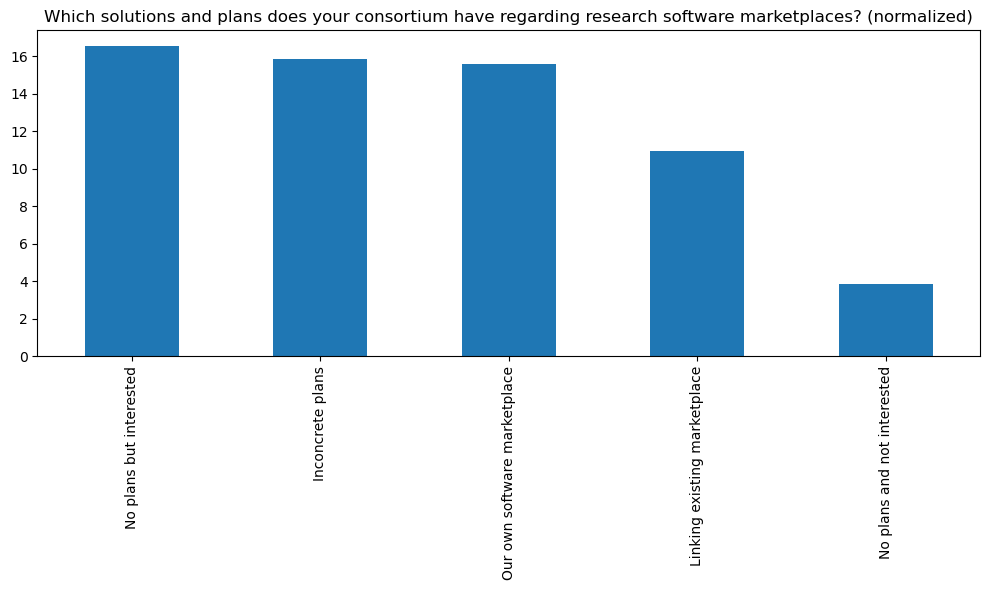

In [21]:
col_count("solutions","Which solutions and plans does your consortium have regarding research software marketplaces?")
_ = col_count_normalize("solutions","Which solutions and plans does your consortium have regarding research software marketplaces?")

#def legend(prefix):
#    keys = set(reduce(lambda a,b: a.union(b), df[prefix]))
#    #keys.remove("UNSURE")
#    df = df_codes[columns=keys]
#    return df
#display(legend("solutions"))

## Participants

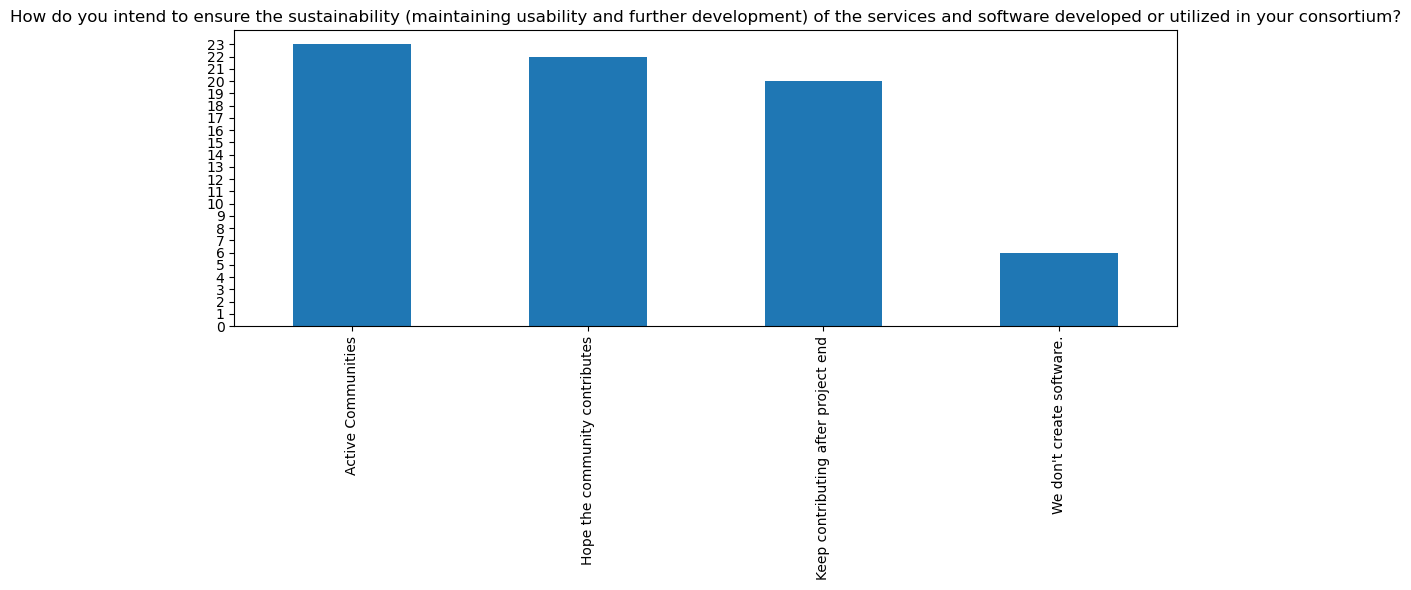

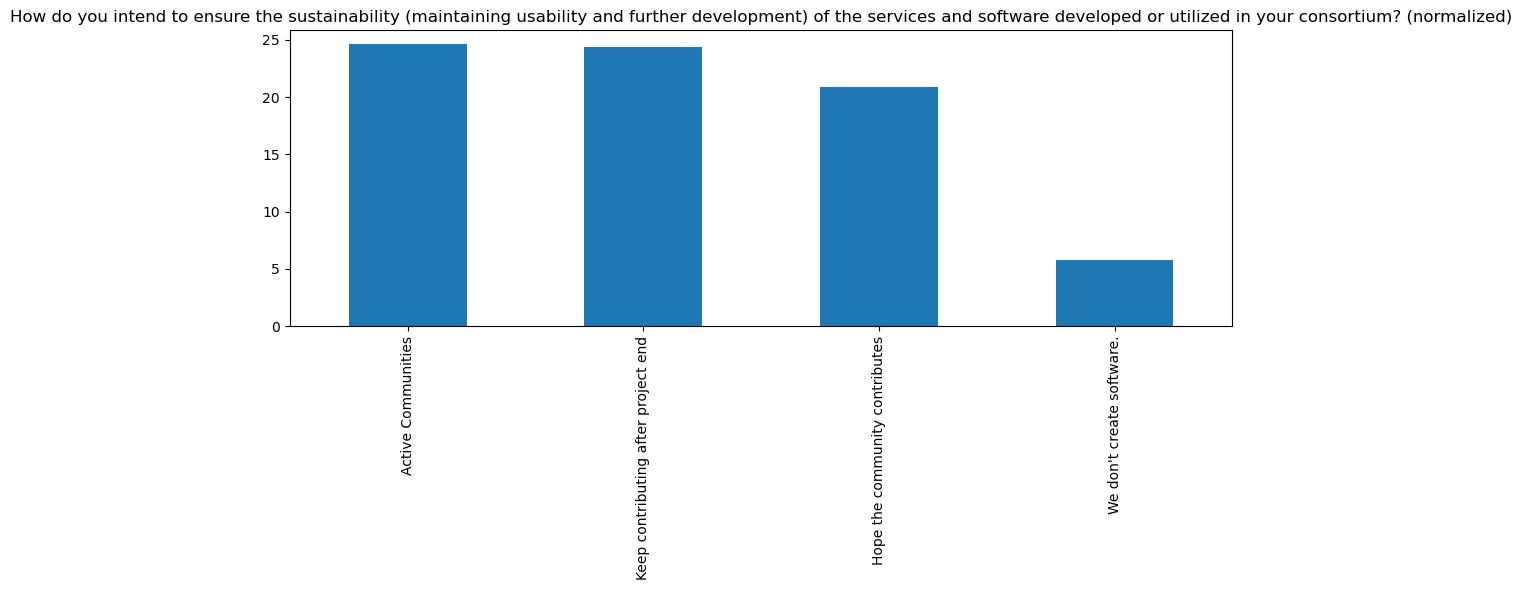

In [22]:
col_count("sustain","How do you intend to ensure the sustainability (maintaining usability and further development) of the services and software developed or utilized in your consortium?")
_ = col_count_normalize("sustain","How do you intend to ensure the sustainability (maintaining usability and further development) of the services and software developed or utilized in your consortium?")

## Participants

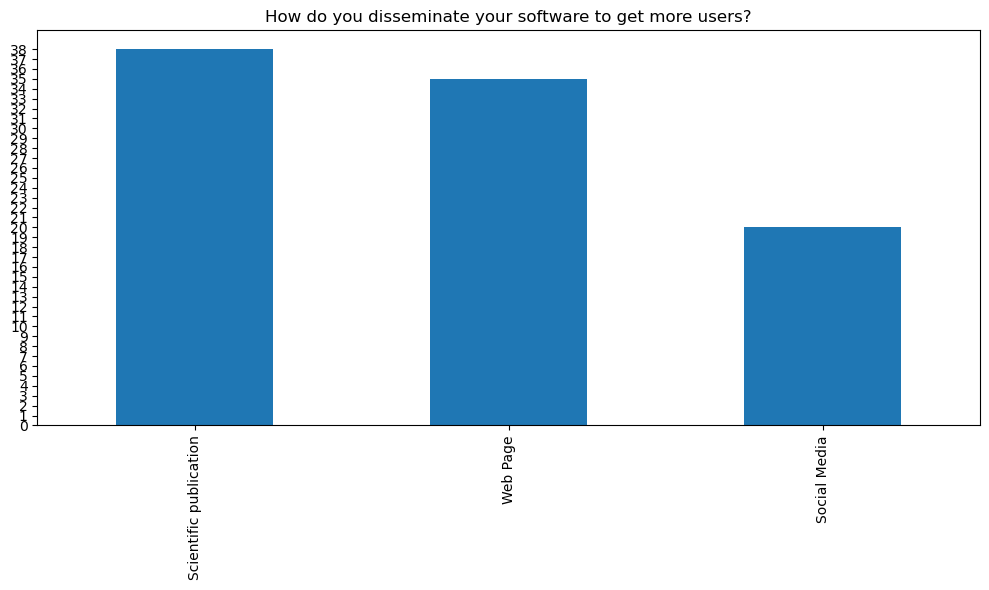

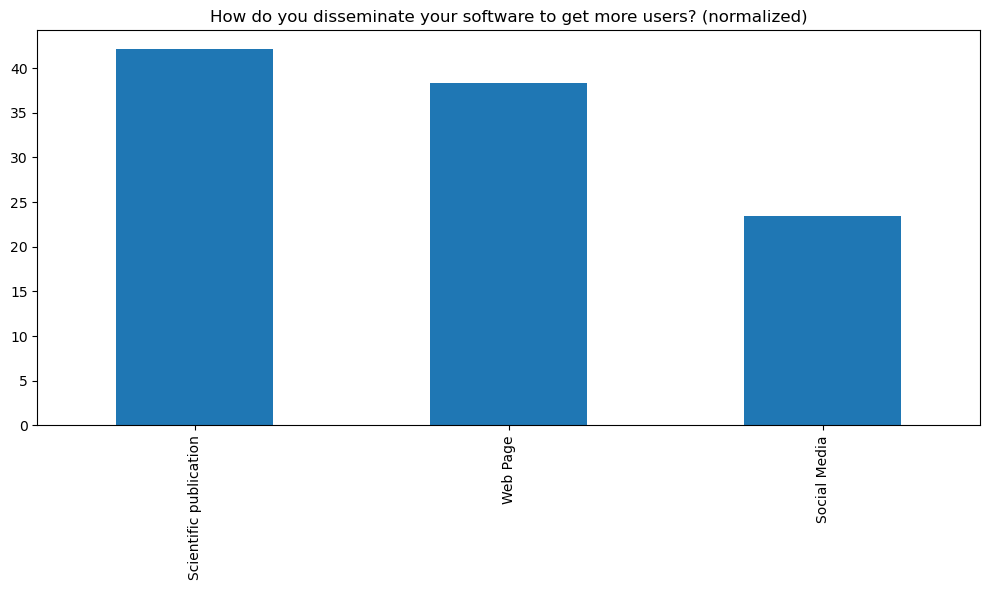

In [23]:
col_count("disseminate","How do you disseminate your software to get more users?")
_ = col_count_normalize("disseminate","How do you disseminate your software to get more users?")

## Participants

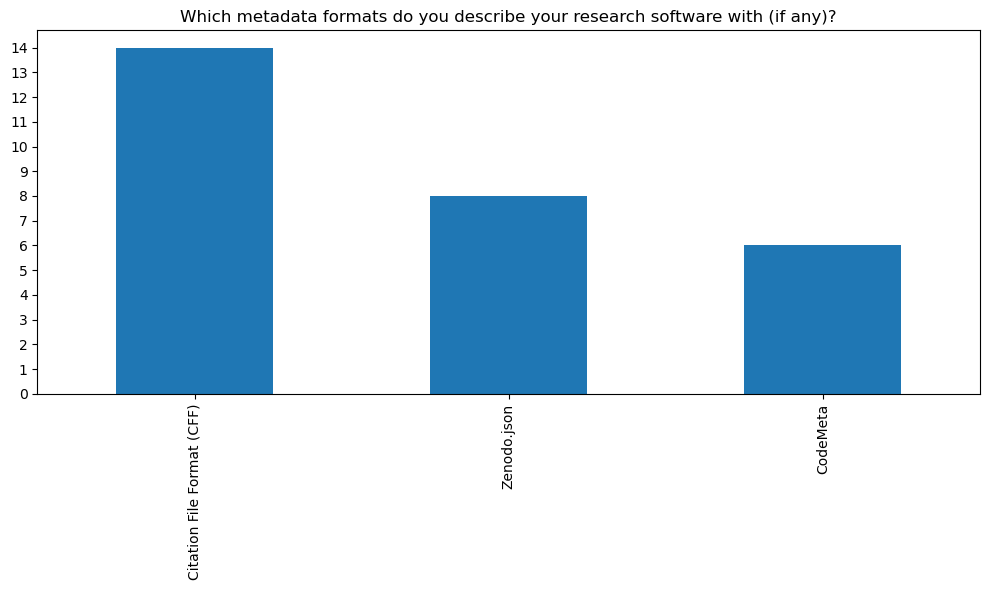

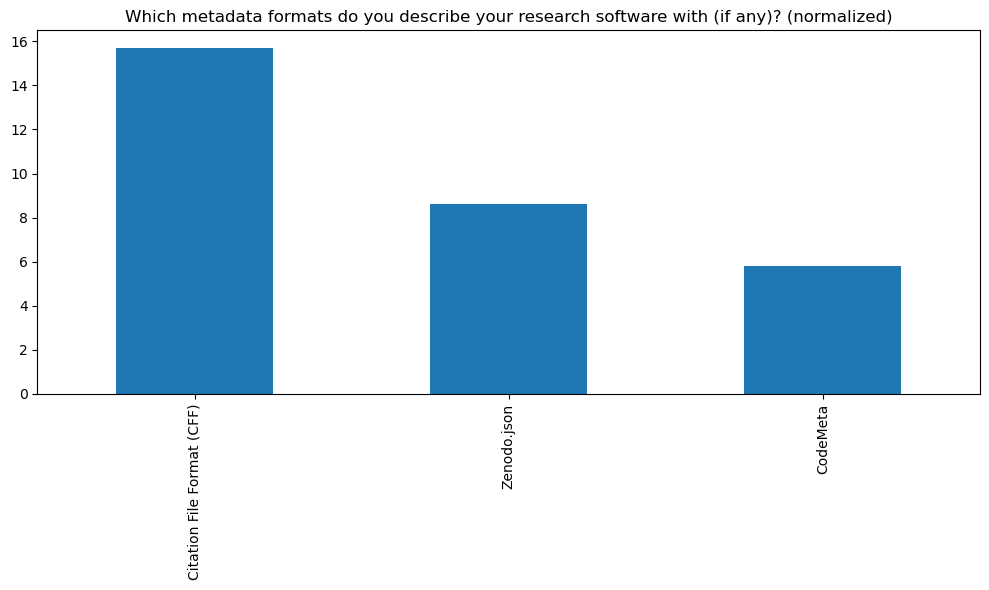

In [24]:
col_count("metadata","Which metadata formats do you describe your research software with (if any)?")
_ = col_count_normalize("metadata","Which metadata formats do you describe your research software with (if any)?")

## Participants

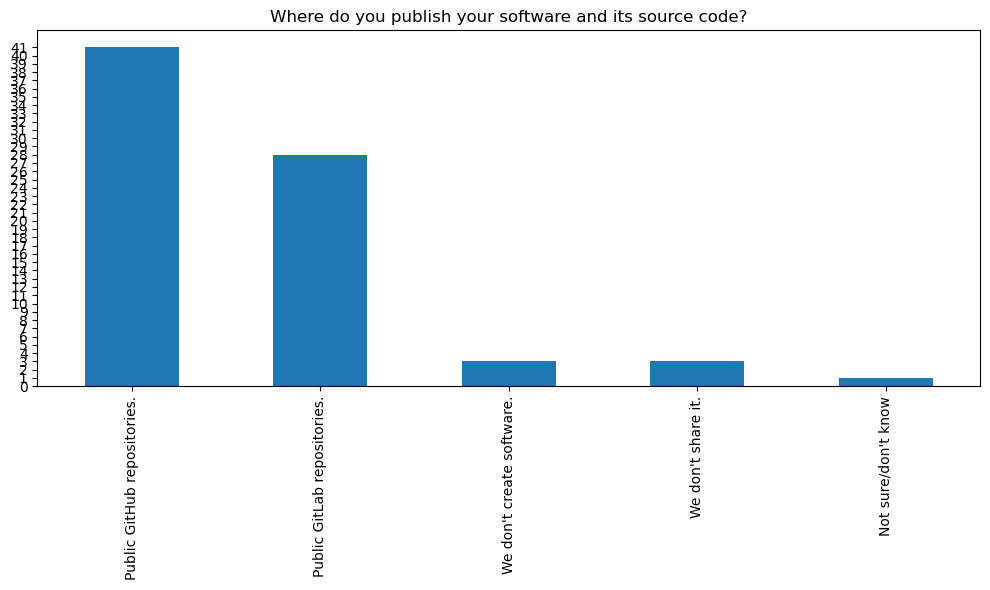

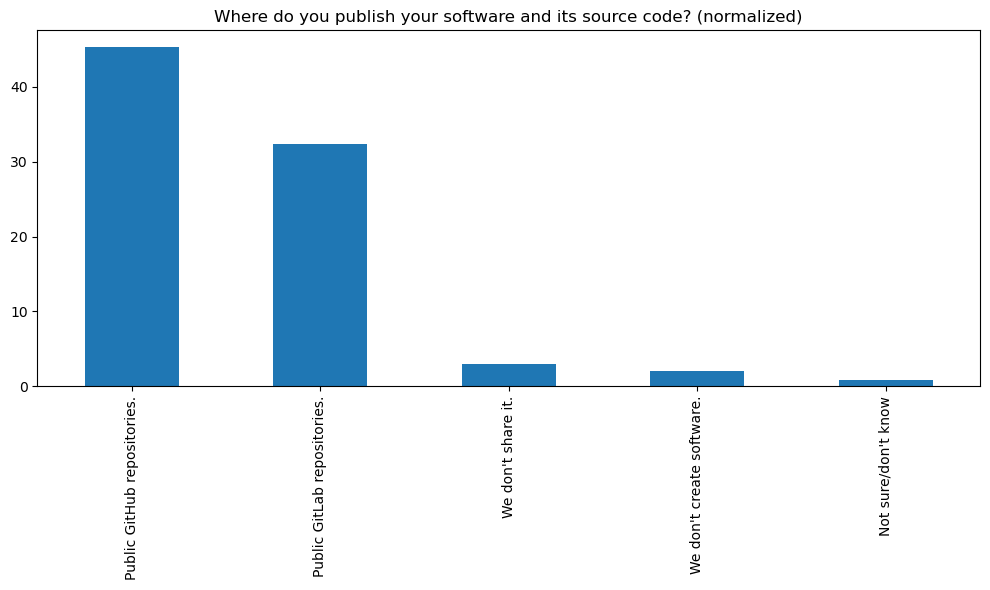

In [25]:
col_count("sourcecode","Where do you publish your software and its source code?")
_ = col_count_normalize("sourcecode","Where do you publish your software and its source code?")

## Participants

The problem with all those answers is that they are strongly biased by different participation ranging from 0 to 11 answers per consortium.
Thus we also look into the normalized values.
Ideally, there should be identical answers within each consortium but we suspect this won't be the case in practise, so we also look at the differences.
However the non-normalized values also shouldn't be discounted because if we assume participation is correlated with consortium size (or expressed in another way the probability of answering is not correlated by the consortium), then we can just treat the non-normalized values as samples from the whole of NFDI and the answers as based on the individual practises.
For example, if Persons A and B both belong to consortium C, and A answers GitHub and B answers GitLab to the source code question, then this doesn't need to mean that one got the answer wrong, just that there is no single answer that is valid for all people in that consortium.

Now that we have created all the aggregate columns, we can create a printable version for the document at the end.

## Participants

In [26]:
cols  = [ 'consortium', 'role', 'solutions', 'sustain', 'disseminate', 'metadata', 'sourcecode']
for col in cols:
    df[col] = df[col].apply(format_set)

table_all = df.to_latex(columns=cols, index=False)
print(table_all)
with open('table_all.tex', 'w') as f:
    f.write(table_all)

\begin{tabular}{lllllll}
\toprule
consortium & role & solutions & sustain & disseminate & metadata & sourcecode \\
\midrule
NFDI4Cat & Administrator, Manager, Software Developer & Linking existing marketplace & Active Communities, Hope the community contributes, Keep contributing after project end, We don't create software. & Scientific publication, Social Media, Web Page & Citation File Format (CFF), Zenodo.json & Public GitHub repositories. \\
NFDI4Biodiversity & Administrator, Researcher, Software Developer & Our own software marketplace & Keep contributing after project end & Scientific publication & Citation File Format (CFF) & Public GitHub repositories. \\
NFDI4Microbiota & Manager & Inconcrete plans, Linking existing marketplace, No plans but interested & Active Communities, Hope the community contributes, Keep contributing after project end & Scientific publication, Web Page &  & Public GitHub repositories., Public GitLab repositories., We don't share it. \\
NFDI-MatWerk & Sof